In [27]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import codecs
import os

from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

# %matplotlib notebook

# Load Data to pandas dataframe

In [3]:
train = pd.read_csv('./data/training_variants')
test = pd.read_csv('./data/test_variants')
# text file in train data: the full papers for each row
trainx = pd.read_csv('./data/training_text', sep="\|\|", engine='python', header=None, skiprows=1,
                     names=["ID", "Text"])
# text file in text data: the full papers for each row
testx = pd.read_csv('./data/test_text', sep="\|\|", engine='python', header=None, skiprows=1,
                    names=["ID", "Text"])

train = pd.merge(train, trainx, how='left', on='ID')
test = pd.merge(test, testx, how='left', on='ID')

print ('train data:')
display(train.head())
print ('test data:')
display(test.head())

train data:


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


test data:


,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


# An overview of the train and test data
Provides the basic statistic of the train and test data, including the size of data, the existence of missing data and the frequency plots.

The Gene contained in train and test data may have a large discrepancy. Test data is almost independent of the train data. This means it is impossible to just use gene and variance data in Train data to perform a correct classification of Test data. The text document is necessary to be explored.

Distribution of train data will not provide much useful information for classification on test data. Supervised learning methods like k-nearest neighborhood, svm, decision tree... will not work well, unless there is some resonable way to embedding the Gene and Variations. Maybe a proper way is to employ some topic models, similar like LDA.

In [4]:
#Check data
# train_shape = train.shape
# test_shape = test.shape
# dc = train.columns
print('train data columns: ' + str(train.columns.values))
print('train data size: ' + str(train.shape))

print('\ntest data columns: ' + str(test.columns.values))
print('test data size: ' + str(test.shape))
print ('\033[91m' + '\033[1m')
print ('Number of Genes in train: {}'.format(len(set(train.Gene.values))))
print ('Number of Genes in test: {}'.format(len(set(test.Gene.values))))
print('Genes in train but not in test: {}'.format(len(set(train.Gene.values).difference(set(test.Gene.values)))))

print ('\nNumber of Variation in train: {}'.format(len(set(train.Variation.values))))
print ('Number of Variation in test: {}'.format(len(set(test.Variation.values))))
print('Variation differnces between train and test: {}'.format(
    len(set(train.Variation.values).difference(set(test.Variation.values))))
     )
print ('\nNumber of Text in train: {}'.format(len(set(train.Text.values))))
print ('Number of Text in test: {}'.format(len(set(test.Text.values))))
print('Text differnces between train and test: {}'.format(len(set(train.Text.values).difference(set(test.Text.values)))))
print ('\033[0m')

train data columns: ['ID' 'Gene' 'Variation' 'Class' 'Text']
train data size: (3321, 5)

test data columns: ['ID' 'Gene' 'Variation' 'Text']
test data size: (5668, 4)

Number of Genes in train: 264
Number of Genes in test: 1397
Genes in train but not in test: 110

Number of Variation in train: 2996
Number of Variation in test: 5628
Variation differnces between train and test: 2981

Number of Text in train: 1921
Number of Text in test: 5611
Text differnces between train and test: 1779



### There is no missing data.

In [5]:
has_nan_trian = train.isnull().sum()
print('train has nan? ')  
display(has_nan_trian)

train has nan? 


ID           0
Gene         0
Variation    0
Class        0
Text         0
dtype: int64

### Gene, Variation and classes most frequently appear
These tables demonstated the row variables or their combinations (last two tables) with highest frequences.


In particular, it can be observed from the 4th table that there are cases that the same gene is associated to two classes. From the contingency table, we find this situation occurs very common in the data.

The most frequent Variations are: Truncating mutations, deletion, amplification and fussion


In [44]:
train['count'] = 1
# fig = plt.figure()
for df_key in ['Gene', 'Variation', 'Class', ['Gene', 'Class'], ['Variation', 'Class']]:
    key_count= train.groupby(df_key)[['count']].count()
    display(key_count.sort_values('count', ascending=False).head(10))

,count
Gene,
BRCA1,264
TP53,163
EGFR,141
PTEN,126
BRCA2,125
KIT,99
BRAF,93
ALK,69
ERBB2,69


,count
Variation,
Truncating Mutations,93
Deletion,74
Amplification,71
Fusions,34
Overexpression,6
G12V,4
Q61L,3
Q61R,3
E17K,3


,count
Class,
7,953
4,686
1,568
2,452
6,275
5,242
3,89
9,37
8,19


count
Gene  Class       
PTEN  4        115
BRCA1 5         90
EGFR  7         84
BRCA2 6         84
TP53  1         83
      4         67
BRCA1 1         60
      6         53
KIT   7         52
BRAF  7         48

,,count
Variation,Class,
Truncating Mutations,1,89
Deletion,1,57
Amplification,7,40
Fusions,2,31
Amplification,2,21
Deletion,4,16
Amplification,6,10
Overexpression,7,4
G12V,7,4


In [7]:
GC = pd.crosstab(train['Class'], train['Gene'])
display(GC)

Gene,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,TSC1,TSC2,U2AF1,VEGFA,VHL,WHSC1,WHSC1L1,XPO1,XRCC2,YAP1
Class,,,,,,,,,,,,,,,,,,,,,
1,0,0,4,0,0,0,0,3,2,0,...,3,23,0,0,15,0,0,0,2,0
2,24,1,1,3,1,1,7,0,1,1,...,0,0,0,0,0,0,0,1,0,3
3,0,0,0,3,0,0,10,0,0,0,...,6,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,2,0,0,...,10,23,0,0,23,0,0,0,0,0
5,0,0,0,3,0,0,5,0,3,0,...,1,0,0,0,2,0,0,0,0,0
6,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,1,0,1,1,0,0
7,2,2,0,17,8,3,47,0,10,6,...,0,1,0,1,0,1,0,0,0,1
8,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,2,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0


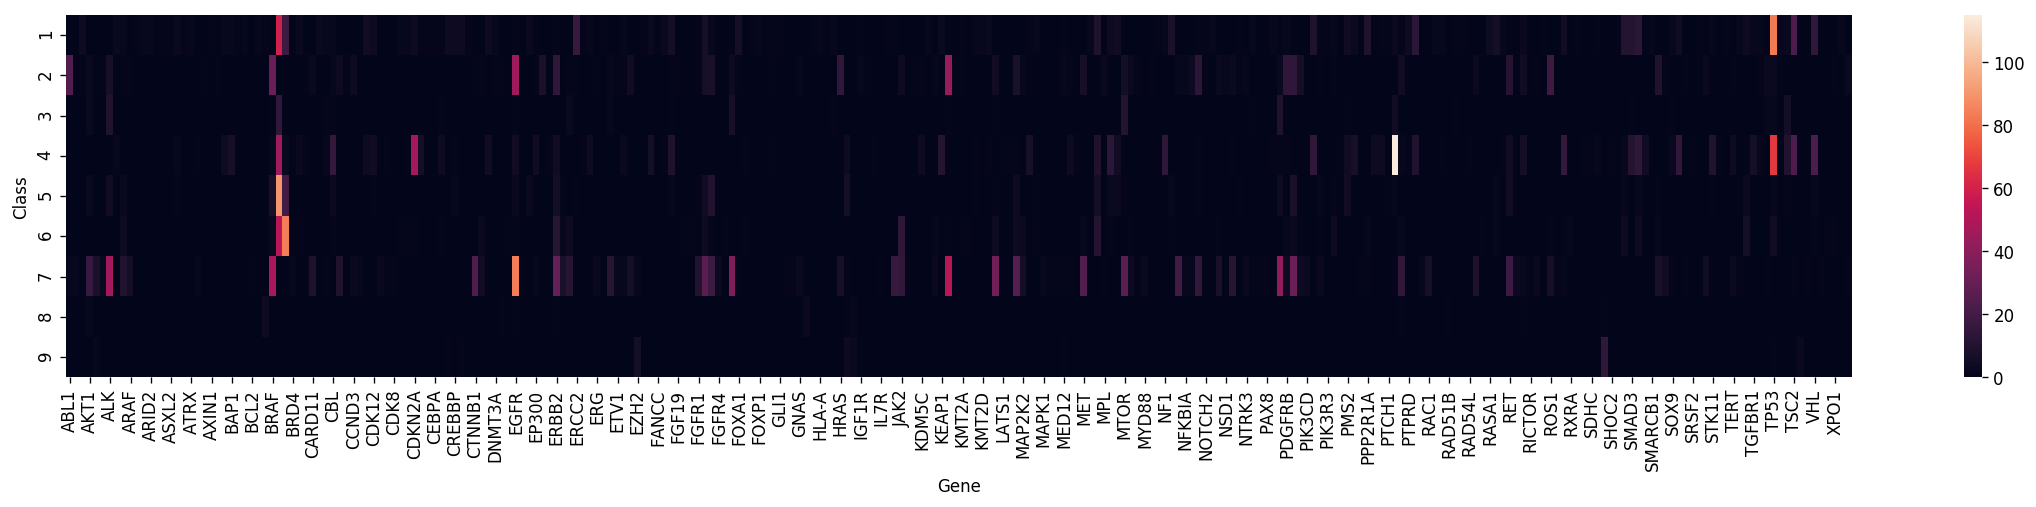

In [36]:
plt.figure(num=None, figsize=(24, 4), dpi=120, facecolor='w', edgecolor='k')
sns.heatmap(GC, vmin=0)
plt.show()

In [37]:
# contigency table of Variation and Classes
VC = pd.crosstab(train['Class'], train['Variation'])
display(VC)

Variation,1_2009trunc,2010_2471trunc,256_286trunc,3' Deletion,385_418del,422_605trunc,533_534del,534_536del,550_592del,560_561insER,...,Y87N,Y901C,Y931C,Y98H,Y98N,YAP1-FAM118B Fusion,YAP1-MAMLD1 Fusion,ZC3H7B-BCOR Fusion,ZNF198-FGFR1 Fusion,p61BRAF
Class,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


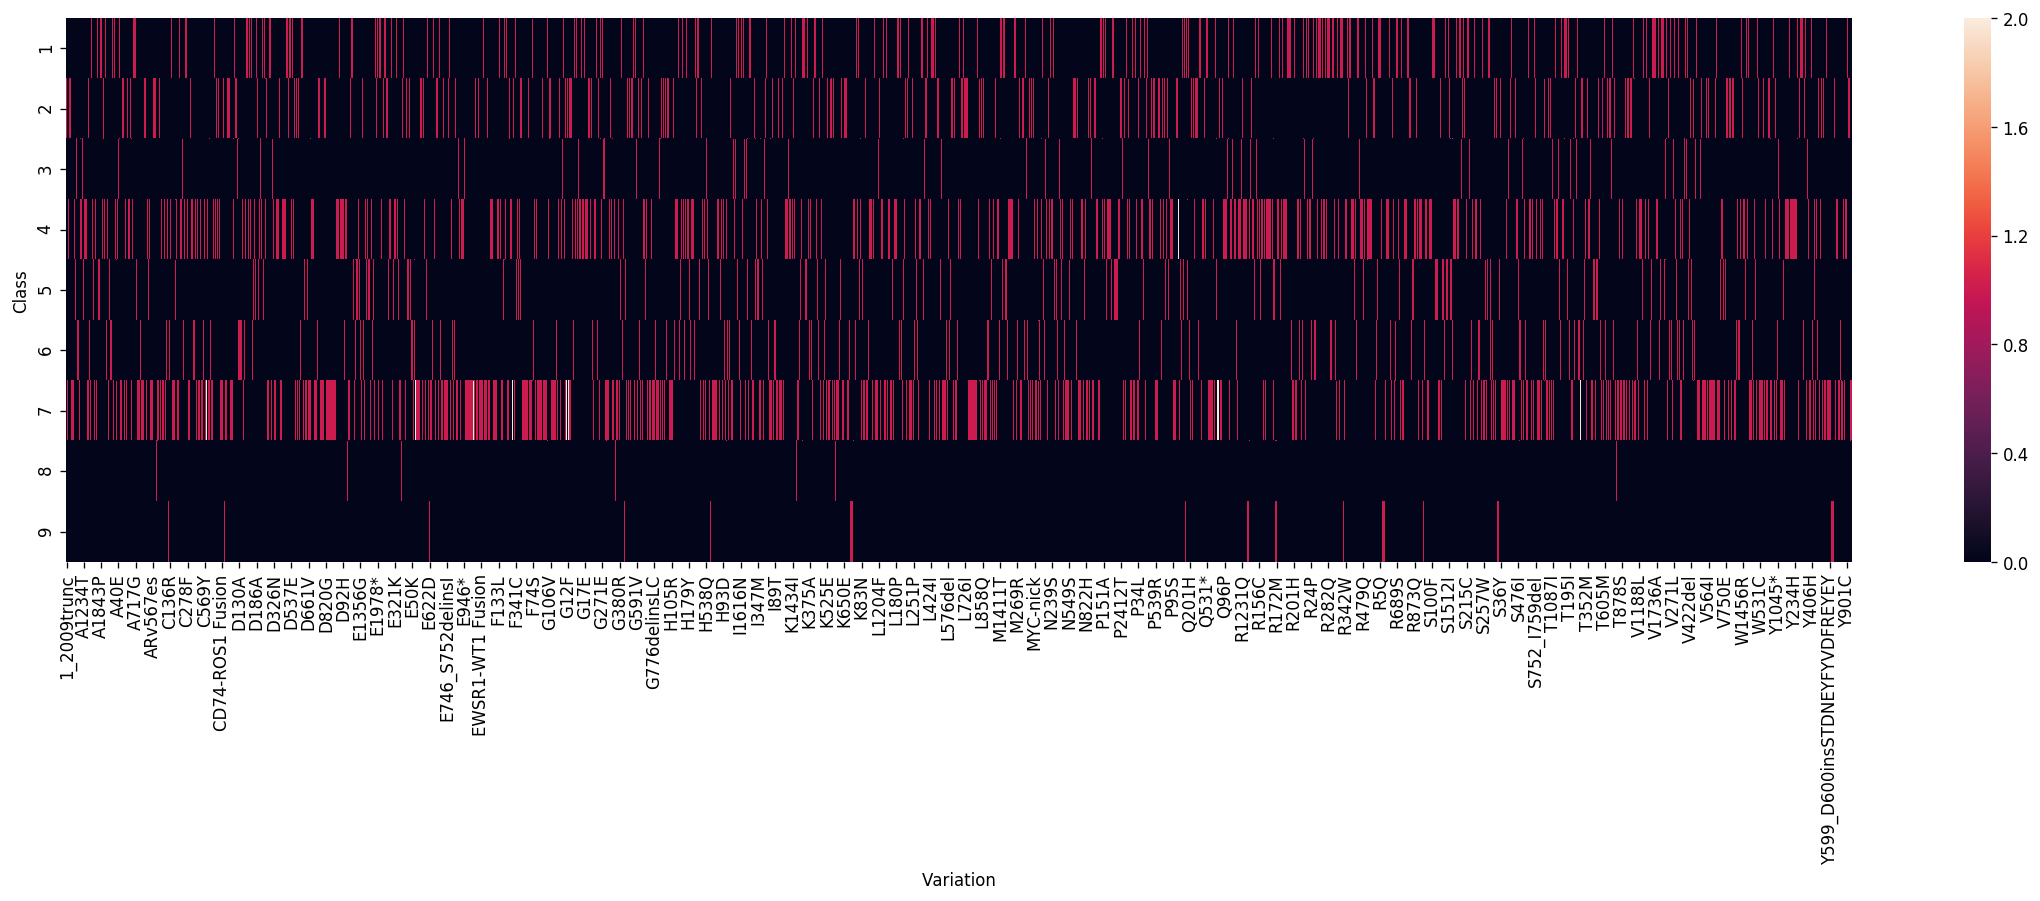

In [24]:
plt.figure(num=None, figsize=(24, 6), dpi=120, facecolor='w', edgecolor='k')
sns.heatmap(VC, vmin=0, vmax=2)
plt.show()

### Histogram plots of the frequency

The frequency of variables is plotted in the histogram in descending order. 

These plots indicated large heterogeneity within each column of the train data table (unbalanced data). Some item appears frequently, however, some items vary rare. This may make classification difficult. Conventional algorithms applied to unbalanced data are often biased towards the majority class. We can assume the classed of the test data have the similar distribution.

The loss function for the selected training algorithms also needs to be selected carefully. As observed from the frequency plot for classes, the number of class 7 is around 100 times higher than those from classes 9 and 8. At least the loss function needs to be weighted by the frequency of different classes, according to Bayes rule. 

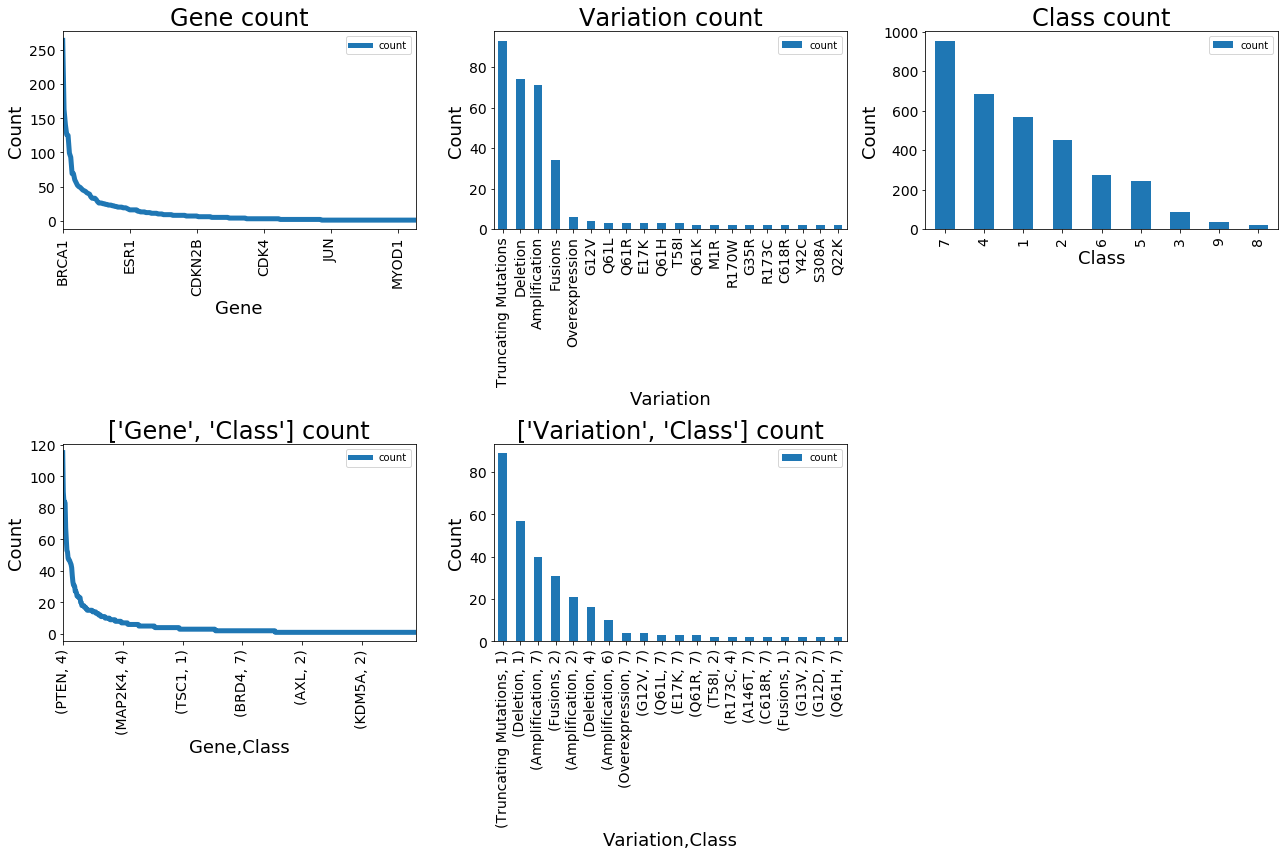

In [6]:
%matplotlib inline

f, a = plt.subplots(2,3)
f.set_size_inches(50, 70)
    
i =0
for df_key in ['Gene', 'Variation', 'Class', ['Gene', 'Class'], ['Variation', 'Class']]:
    key_count= train.groupby(df_key)[['count']].count()
    if df_key == 'Class':
        ax = a[i//3, i%3]
        ax.set_xlabel(df_key,fontsize=18)
        ax.set_ylabel("Count",fontsize=18)
        ax.set_title(str(df_key) +" count",fontsize= 24)
        key_count.sort_values('count', ascending=False).plot(kind='bar', ax=ax, figsize=(18,12),legend=True, fontsize=14, rot=90)
    elif df_key == 'Variation' or df_key == ['Variation', 'Class'] :
        ax = a[i//3, i%3]
        ax.set_xlabel(df_key,fontsize=18)
        ax.set_ylabel("Count",fontsize=18)
        ax.set_title(str(df_key) +" count",fontsize= 24)
        key_count.sort_values('count', ascending=False).head(20).plot(kind='bar', ax=ax, figsize=(18,12),legend=True, fontsize=14, rot=90)
    else:
        ax = a[i//3, i%3]
        ax.set_xlabel(df_key,fontsize=18)
        ax.set_ylabel("Count",fontsize=18)
        ax.set_title(str(df_key) +" count",fontsize= 24)
        key_count.sort_values('count', ascending=False).plot(ax=ax, linewidth=5,figsize=(18,12),legend=True, fontsize=14, rot=90)
    i+=1
f.delaxes(a.flatten()[5])
plt.tight_layout()



# Similar analysis for test data

## Frequency analysis

In [7]:
test['count'] = 1
# fig = plt.figure()
for df_key in ['Gene', 'Variation']:
    key_count= test.groupby(df_key)[['count']].count()
    display(key_count.sort_values('count', ascending=False).head(10))

,count
Gene,
F8,134
CFTR,57
F9,54
G6PD,46
GBA,39
PAH,38
AR,38
CASR,37
ARSA,30


,count
Variation,
Truncating Mutations,18
Deletion,14
Amplification,8
Fusions,3
G44D,2
A101V,1
R236S,1
R242T,1
R241P,1


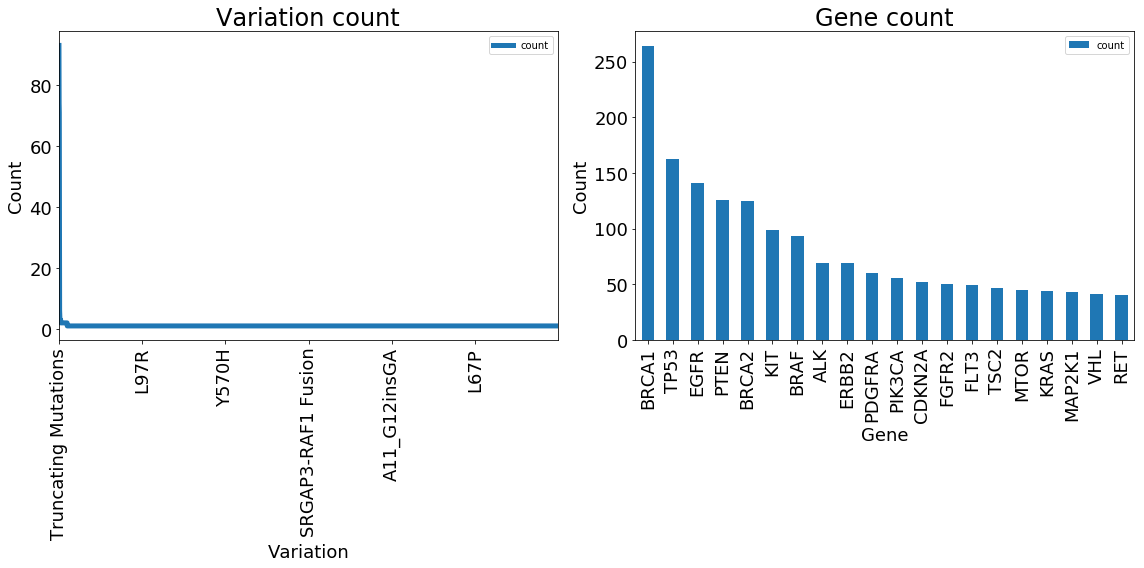

In [8]:
# %matplotlib inline

f, a = plt.subplots(1,2)
f.set_size_inches(16, 8)

i =0
for df_key in ['Gene', 'Variation']:
    key_count= train.groupby(df_key)[['count']].count()
    if df_key == 'Variation' or df_key == ['Variation', 'Class'] :
        ax = a[0]
        ax.set_xlabel(df_key,fontsize=18)
        ax.set_ylabel("Count",fontsize=18)
        ax.set_title(str(df_key) +" count",fontsize= 24)
        key_count.sort_values('count', ascending=False).plot(ax=ax, linewidth=5, figsize=(16,8),legend=True, fontsize=18, rot=90)
    else:
        ax = a[1]
        ax.set_xlabel(df_key,fontsize=18)
        ax.set_ylabel("Count",fontsize=18)
        ax.set_title(str(df_key) +" count",fontsize= 24)
        key_count.sort_values('count', ascending=False).head(20).plot(kind='bar', ax=ax,figsize=(16,8),legend=True, fontsize=18, rot=90)
    i+=1
plt.tight_layout()


# Feature interactions

## Gene VS Classes distribution in train data 

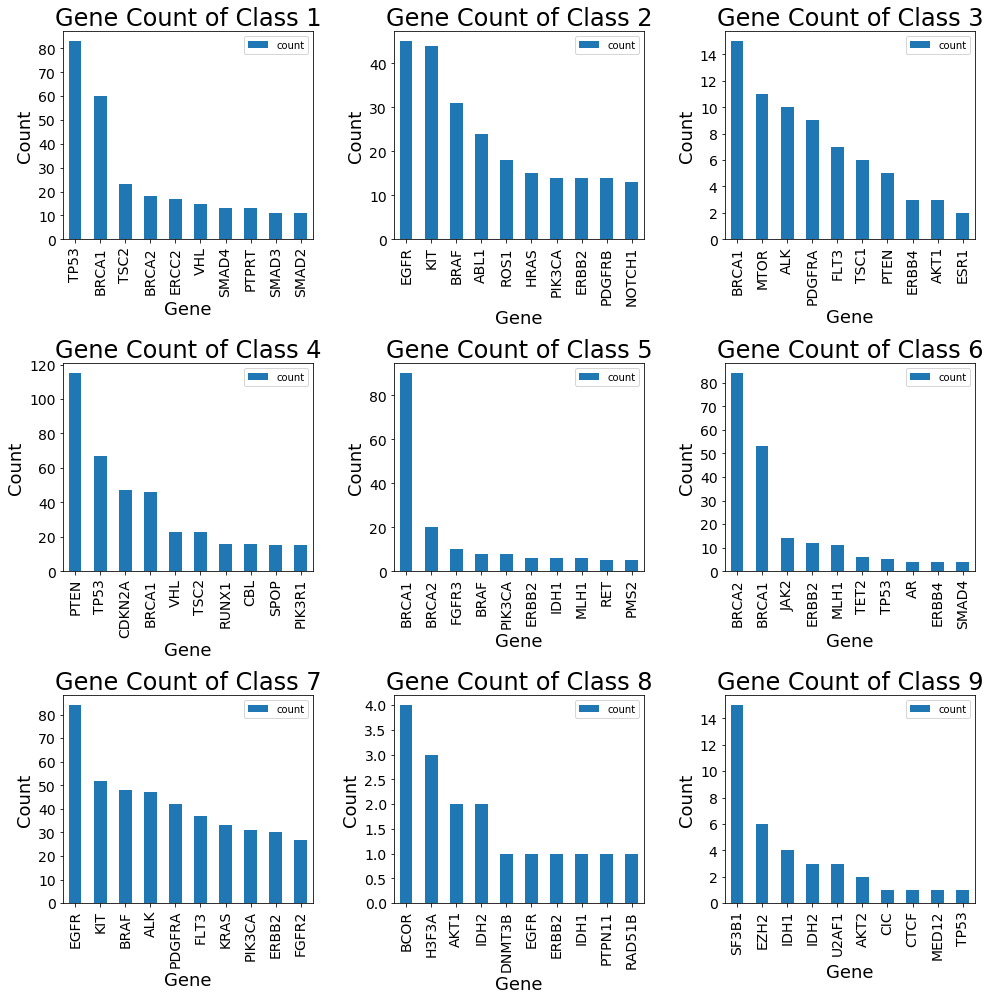

In [9]:
df_agg = train.groupby(['Class', 'Gene']).agg({'count':sum})
g = df_agg.groupby(level=0)
# g = df_agg.groupby(level=1)
class_gene = g.apply(lambda x:x.sort_values('count', ascending=False).head(10))

dff = class_gene.xs(3)
dff.reset_index(level=0)
f, a = plt.subplots(3,3)
f.set_size_inches(40,40)
for i in range(9):
    ax = a[int(i/3), i%3]
    ax.set_xlabel('Gene',fontsize=18)
    ax.set_ylabel('Count',fontsize=18)
    ax.set_title("Gene Count of Class %d" % (i+1),fontsize= 24)
    class_gene.xs(i+1).reset_index(level=0)['count'].plot(kind='bar', ax=ax,figsize=(14,14),legend=True, fontsize=14, rot=90)
    'Gene'
plt.tight_layout()

## Gene VS Variation plot for train and test data
On most of the Genes, several Variations can be observed and vice versa. Here the Gene VS Variation plot is made for Train and Text data. The Gene names and Variation names are encoded for plotting. 

It can be observed that in train data some genes have more variations than other ones. This is not obvious in the test data. 


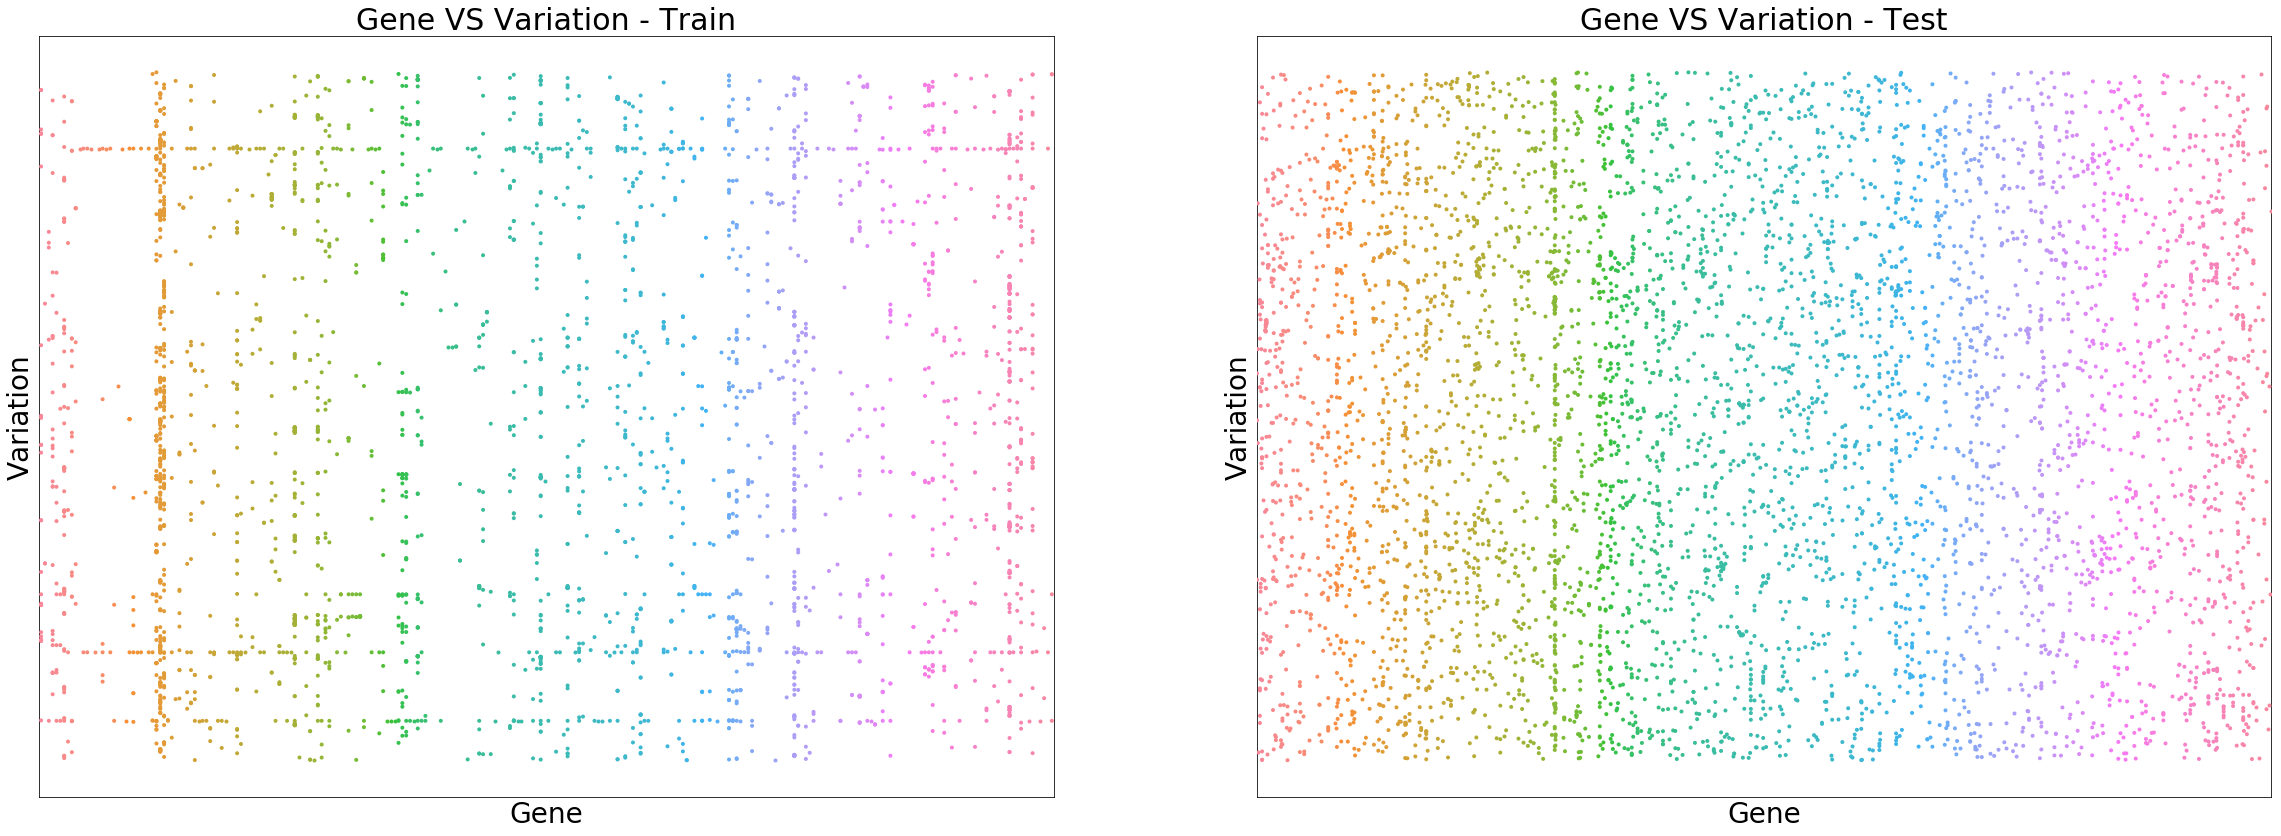

In [10]:
# Gene VS Variesation plot for train and test data
from sklearn.preprocessing import LabelEncoder

gene_variation_train = train[['Gene', 'Variation']].copy()
gene_variation_test = test[['Gene', 'Variation']].copy()

lec = LabelEncoder()
lec.fit(train['Variation'].append(test['Variation']))


gene_variation_train['Variation'] = lec.transform(gene_variation_train['Variation'])
gene_variation_test['Variation'] = lec.transform(gene_variation_test['Variation'])

lec.fit(train['Gene'].append(test['Gene']))
gene_variation_train['Gene'] = lec.transform(gene_variation_train['Gene'])
gene_variation_test['Gene'] = lec.transform(gene_variation_test['Gene'])

f, (ax1, ax2) = plt.subplots(1,2);
f.set_size_inches(40,14);

sns.stripplot(x="Gene", y="Variation",  size = 4, data=gene_variation_train, ax=ax1);

ax1.set_yticks([]);
ax1.set_xticks([]);
ax1.set_xlabel('Gene',fontsize=28);
ax1.set_ylabel('Variation',fontsize=28);
ax1.set_title('Gene VS Variation - Train',fontsize= 30);


sns.stripplot(x="Gene", y="Variation", size = 4, data=gene_variation_test, ax=ax2);

ax2.set_yticks([]);
ax2.set_xticks([]);
ax2.set_xlabel('Gene',fontsize=28);
ax2.set_ylabel('Variation',fontsize=28);
ax2.set_title('Gene VS Variation - Test',fontsize= 30);

## Analyse correlation of Gene and Class

In [11]:
def edit_dist_matrix(seq1, seq2):
    num_rows = np.max(seq1.shape)
    num_cols = np.max(seq2.shape)
    
    dist_mat = np.zeros([num_rows, num_cols])
    
    for i in range(num_rows):
        for j in range(num_cols):
            dist_mat[i,j] = int(editdistance.eval(seq1[i], seq2[j]))
            
    return dist_mat
    
def class_dist_matrix(seq1, seq2):
    num_rows = np.max(seq1.shape)
    num_cols = np.max(seq2.shape)
    
    class_dist_mat = np.zeros([num_rows, num_cols])
    
    for i in range(num_rows):
        for j in range(num_cols):
            class_dist_mat[i,j] = 1-int(seq1[i]==seq2[j])
            
    return class_dist_mat

In [12]:
seq_variation_class = train[['Variation', 'Class']].sort_values(by='Variation')
seq_gene_class = train[['Gene', 'Class']].sort_values(by='Gene')

# Text data analysis

## Simple text overviews

In [ ]:
train['Text_length'] = train['Text'].apply(lambda x: len(str(x).split(' ')))
test['Text_length'] = test['Text'].apply(lambda x: len(str(x).split(' ')))

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import spacy
import pyLDAvis.sklearn
import codecs
import os

nlp = spacy.load('en')

## Tokens and phrases analysis

### Token extraction - extract professional vocabularies from papers

The research papers contain lots of word tokens which provide few medical related information. These redundant tokens may disturb the text data analysis. The medical professional vocabularies are extracted from each paper. These professional vocabularies represent the paper. It may be regarded as a compress of the paper. The original texts are compressed approximately to 10% ~ 15%.

Below, the text analysis only performed on tree paper texts for demonstration. A similar analysis is applied to the full data set for feature extraction.


In [14]:
import random
train_text =  train.head(3)['Text'].copy().values

print ('length of texts: ' + str([len(text) for text in train_text]))

length of texts: [39672, 36691, 36691]


In [15]:
# Generator of text lists contained in data set
def decode_text(text_list):
    for text in text_list:
        yield text

# Find the professional tokens in a paper Text
def prof_tokens (text_list):
    for parsed_text in nlp.pipe(decode_text(text_list),
                               batch_size = 10,
                               n_threads=4):
        
        prof_token = [token.lemma_ for token in parsed_text 
                      if token.is_oov # exclude the most commonly used English word in general texts.
                      and not token.is_space
                      and not token.like_num # remove the numbers
                      and not token.is_digit
                      and not token.suffix_.endswith('%')
                      and (token.is_ascii | any(u"\u03B1" <= c <= u"\u03C9" for c in token.text)) # include Greek symbols
                      and not token.is_bracket
                      and not token.like_url and token.__len__()< 15] # remove url and DNA sequences
        
        yield u' '.join(prof_token)


In [16]:
prof_tokens_of_texts = [prof_text for prof_text in prof_tokens(train_text)]
print ('length of prof tokens: ' + str([len(prof_text) for prof_text in prof_tokens_of_texts]))

length of prof tokens: [7252, 4604, 4604]


### Phrase Modeling - bigrams and trigrams

In [17]:
# Phrase Modeling
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence, Dictionary

/home/gongbo/anaconda2/envs/myenv3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [18]:
unigram_text_filepath = os.path.join('./data', 'eda_unigram_text.txt')

with codecs.open(unigram_text_filepath, 'w', encoding='utf-8') as f:
    for tokens in prof_tokens(train_text):
        f.write(tokens + '\n')

In [19]:
unigram_text = LineSentence(unigram_text_filepath)
bigram_model = Phrases(unigram_text)

In [20]:
bigram_text_path = os.path.join('./data', 'eda_bigram_text.txt')

with codecs.open(bigram_text_path, 'w', encoding='utf-8') as f:
    for unigram_tokens in unigram_text:
        bigram_pharse = u' '.join(bigram_model[unigram_tokens])
        f.write(bigram_pharse + '\n')

In [21]:
bigram_text = LineSentence(bigram_text_path)
trigram_model = Phrases(bigram_text)

trigram_text_path = os.path.join('./data', 'eda_trigram_text.txt')
with codecs.open(trigram_text_path, 'w', encoding='utf-8') as f:
    for bigram_pharse in unigram_text:
        trigram_pharse = u' '.join(trigram_model[bigram_pharse])
        f.write(trigram_pharse + '\n')

In [22]:
trigram_phrases = LineSentence(trigram_text_path)

for trigram_pharse in trigram_phrases:
    print (u' '.join(set([token for token in trigram_pharse if token.find('_')>0])))

nm_152274.2 v5_6his ubiquitin_ligase
72515_72517 tyrosine_kinase q249e_w802 ubiquitin_ligase
72515_72517 tyrosine_kinase q249e_w802 ubiquitin_ligase


## Explore the Gene, Variation and Text relation

We encode the text data by the gene and variation. Each text is encoded as a binary list. 

variation data from train and test data is collected to make an dictionary. For each text document, a list containing 0 and 1 will be generated. The i-th entry of the list is 1, if the i-th variation in the variation dictionary can be found in the text document. 

Same for the gene dictionary. 

In [34]:
bow_variation = np.append(train['Variation'].values, test['Variation'].values)
bow_variation_utf = u' '.join([token.decode('utf-8') for token in bow_variation])
bow_variation_tokens = nlp(bow_variation_utf)

# using set comprehension to remove duplications
token_lemmatize = {token.lemma_ for token in bow_variation_tokens if token.__len__()> 2} 

variation_bow_path = os.path.join('./data', 'eda_variation_bow.txt')
with codecs.open(variation_bow_path, 'w', encoding='utf-8') as f:
    f.write(u' '.join(token_lemmatize))

In [35]:
# size of the variation 
len(token_lemmatize)

8549

In [36]:
train_gene = train[['ID','Gene', 'Variation']]
train_gene_sort = train_gene.sort_values(['Gene', 'Variation'])

# Build bag of words with variations
variation_dict = Dictionary(LineSentence(variation_bow_path))
variation_dict_path = os.path.join('./data', 'eda_variation_dict.dict')

variation_dict.save(variation_dict_path)

#### Example print of the variations appeared in a text

In [40]:
text1 =train['Text'][2150].decode('utf-8')

text1_tokens = nlp(text1)

doc_enc = variation_dict.doc2bow([token.lemma_ for token in text1_tokens])
variances_in_doc =''
for k in variation_dict.token2id:
    if variation_dict.token2id[k] in list(np.array(doc_enc)[:,0]):
        variances_in_doc += u' '+ k
        
print variances_in_doc

 h118p dna fig e157 r130l amplification l112p r130 l108p number the n276s d252 domain n48 loss f241s mutation h123q d326n single overexpression bind g129e g129r upstream a39p truncate deletion c124s h93r missense
